## А вообще косяков здесь много....
UPD вроде уже нет

In [1]:
import math as m
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from copy import deepcopy
import time

In [2]:
class Dragonfly:
    def __init__(
        self, 
        u: np.array(float), 
        f: float
             ):
        self.u = u
        self.f = f
        
class DragonflySwarm:
    def __init__(
        self,
        swarm_size: int,
        dim: int,
        max_iter: int,
        sep: float,
        alignmnt: float,
        cohesn: float,
        tendnsy: float,
        evatn: float,
        weight: float, 
        alpha: float,
        lmbd: float,
        radius: float,
        step_modification: int,
        const_for_modif: float
        #area: List[List[float]],
                 ):
        self.swarm_size = swarm_size
        self.dim = dim
        self.u_dim = dim - 1
        self.max_iter = max_iter
        self.current_iter = 0
        self.sep = sep
        self.alignmt = alignmnt
        self.cohesn = cohesn
        self.tendnsy = tendnsy
        self.evatn = evatn
        self.weight = weight
        self.alpha = alpha
        self.lmbd = lmbd
        self.radius = radius
        self.population = []
        self.sep_list = np.zeros(self.u_dim)
        self.alig_list = np.zeros(self.u_dim)
        self.coh_list = np.zeros(self.u_dim)
        self.food_attract = np.zeros(self.u_dim)
        self.enemy_avoid = np.zeros(self.u_dim) #было array
        self.velocity_list = []# np.zeros(self.u_dim)
        self.euclid_list = []
        self.best_list = []
        self.worst_list = []
        self.exact = 0
        self.best_x1 = []
        self.best_x2 = []
        self.const_for_modif = 0.5#const_for_modif
        self.step_modification = step_modification
    
    
    def init_area(self, control):
        self.area = [np.array([0, 100]) for i in range(control.N_step - 1)] #deleted np.array(*)
        self.exact = control.ExactI()

               
    # the dims are ok now -  the problem was at the dragonfly constructor
    def form_first_pop(self, control):
        self.population.clear()
        for i in range(self.swarm_size):
            coordinate = np.array([np.random.rand() * (self.area[j][1] - self.area[j][0]) + self.area[j][0] 
                          for j in range(self.u_dim)])
            #print(coordinate)
            result = control.Functional(coordinate)
            #print(result)
            member = Dragonfly(coordinate, result)
            self.population.append(member)
            
    def form_first_test(self, control):
        self.population.clear()
        coordinate = [1, 1,  1,  2]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        coordinate = [2, 1 , 1, 2]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        coordinate = [2, 3, 4, 1]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        coordinate = [1, 2, 3, 1]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        coordinate = [1, 3, 5, 1]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        
    def test_form(self, control):
        #tst - это u
        tst = [10, 3]
        result = control.Functional(tst)
        member = Dragonfly(tst, result)
        self.population.append(member)   
        tst = [2, 5]
        result = control.Functional(tst)
        member = Dragonfly(tst, result)
        self.population.append(member)   
        tst = [4, 7]
        result = control.Functional(tst)
        member = Dragonfly(tst, result)
        self.population.append(member) 

        

    
    def generate_step_test(self):
        self.velocity_list.clear()
        for i in range(self.swarm_size):
            velocty = [0.01 for j in range(self.u_dim)]
            tmp = np.zeros(self.u_dim)
            for ind in range(self.u_dim):
                tmp[ind] = velocty[ind]
            self.velocity_list.append(tmp)

    def generate_step_coord(self):
        self.velocity_list.clear()
        for i in range(self.swarm_size):
            velocty = [(self.area[j][1] - self.area[j][0]) * np.random.uniform(-1, 1) / 100
                for j in range(self.u_dim)]
            tmp = np.zeros(self.u_dim)
            for ind in range(self.u_dim):
                tmp[ind] = velocty[ind]
            self.velocity_list.append(tmp)
            
    def move_swarm(self, control):
        self.current_iter += 1
        right_area = False # same as "flag" in a previous C# code 
        
        radius_area = self.radius * self.current_iter / self.max_iter
        trunk_ = self.max_iter - self.max_iter // 2
        
        population_copy = deepcopy(self.population)
        velocity_copy = deepcopy(self.velocity_list)
        
        for i in range(self.swarm_size):
            for j in range(self.swarm_size):
                if i != j:
                    dist = np.linalg.norm(np.array(population_copy[i].u) - np.array(population_copy[j].u))
                    if dist <= radius_area:
                        self.euclid_list.append([j, dist])
            if len(self.euclid_list) > 1:
                #print('Formula')
                self.sep_list = self.separation2(i, population_copy)
                self.alig_list = self.alignment2(i, velocity_copy)
                self.coh_list = self.cohesion2(i, population_copy)
                self.food_attract = self.tendensy2(i, population_copy)
                self.enemy_avoid = self.evation2(i, population_copy)
                #выходит за пределы массива в скорости 25 из 24
                tmp_velo = np.zeros(self.u_dim)
                tmp_velo = self.velocity(i)
                self.velocity_list[i] = tmp_velo #self.velocity_list.append(self.velocity(i))
                
                if (self.current_iter < trunk_):
                    tmp_list = self.find_new_position(i)
                    #print(tmp_list)
                else:
                    tmp_list = self.find_new_position_mod(i, self.step_modification)
                
                
                for ii in range(self.u_dim):
                    #не так все равно tmp_list вектор или вектор векторов?
                    self.population[i].u[ii] = tmp_list[ii]
                self.check_area(i)
            else:
                half_set = int((self.u_dim) / 2)
                r_parameter = []
                theta = []
                l_parameter = []
                xi_parameter = []
                
                
                for ii in range(self.u_dim):
                    iterator_0 = 0
                    while not right_area:
                        r_parameter.append(np.random.rand() * (self.area[ii][1] - self.area[ii][0]) + self.area[ii][0])
                        theta.append(r_parameter[len(r_parameter) - 1] * 2 * np.pi)
                        l_parameter.append(r_parameter[len(r_parameter) - 1] ** self.lmbd)
                        
                        if ii < half_set:
                            xi_parameter.append(l_parameter[len(l_parameter) - 1] * np.sin(theta[len(theta) - 1]))
                        else:
                            xi_parameter.append(l_parameter[len(l_parameter) - 1] * np.cos(theta[len(theta) - 1]))
                                                
                        check_obl = np.array(self.population[i].u[ii]) + \
                        (self.alpha / (self.current_iter + 1)) * xi_parameter[len(xi_parameter) - 1]
                        if (check_obl < self.area[ii][0]) or (check_obl > self.area[ii][1]):
                            right_area = False
                            if iterator_0 > 100:
                                check_obl = np.abs(check_obl) / 2
                                right_area = True
                                break      
                        else:
                            right_area = True
                        iterator_0 += 1
                    right_area = False
                    self.population[i].u[ii] = (self.population[i].u[ii]) + \
                        (self.alpha / (self.current_iter + 1)) * xi_parameter[len(xi_parameter) - 1]
                    #print(self.population[i].u)
                
            self.population[i].f = control.Functional(self.population[i].u)
            self.euclid_list.clear()
            
    def separation(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        for indx, dist in self.euclid_list:
            tmp += (np.array(population_copy[it].u) - np.array(population_copy[indx].u))
        
        print('after summerize: ', tmp, '\n')
        
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] /= 10
            if(np.abs(tmp[i]) >= (area_tmp / 3)):
                tmp[i] = tmp[i] / 3
            tmp[i] = -tmp[i]
        print('after all: ', tmp)
        return tmp
    
    def separation2(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        flag = 0
        for indx, dist in self.euclid_list:
            tmp += (np.array(population_copy[it].u) - np.array(population_copy[indx].u))
        #print('after summerize', tmp, '\n')
        
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            if(np.abs(tmp[i]) >= (area_tmp / 4)):
                flag += 1
        if flag != 0:
            tmp = tmp / 400
        tmp = -tmp
        return tmp
    
    
    def alignment(self, it, velocity_copy):
        tmp = np.zeros(self.u_dim)
        for indx, dist in self.euclid_list:
            tmp_velo = np.array(velocity_copy[indx])
            tmp += tmp_velo
        tmp = tmp / len(self.euclid_list)
        print('after summerize', tmp, '\n')
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] = tmp[i] / 10
            if(np.abs(tmp[i]) >= (area_tmp / 3)):
                tmp[i] = tmp[i] / 3
        print('after all: ', tmp)
        return tmp
    
    def alignment2(self, it, velocity_copy):
        tmp = np.zeros(self.u_dim)
        flag = 0
        for indx, dist in self.euclid_list:
            tmp_velo = np.array(velocity_copy[indx])
            tmp += tmp_velo
            
        tmp = tmp / len(self.euclid_list)
        #print('after summerize', tmp, '\n')
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            if(np.abs(tmp[i]) >= (area_tmp / 4)):
                flag += 1
        if flag != 0:
            tmp = tmp / 400
        #print('after all: ', tmp)
        return tmp
    
    def cohesion(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        for indx, dist in self.euclid_list:
            tmp += np.array(population_copy[indx].u)
        tmp = tmp / len(self.euclid_list) - np.array(population_copy[it].u)
        print('after summerize', tmp, '\n')
        
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] = tmp[i] / 10
            if(np.abs(tmp[i]) >= (area_tmp / 3)):
                tmp[i] = tmp[i] / 3
        print('after all: ', tmp)
        return tmp
    
    
    def cohesion2(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        flag = 0
        for indx, dist in self.euclid_list:
            tmp += np.array(population_copy[indx].u)
        tmp = tmp / len(self.euclid_list) - np.array(population_copy[it].u)
        #print('after summerize', tmp, '\n')
        
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            if(np.abs(tmp[i]) >= (area_tmp / 4)):
                flag += 1
        if flag != 0:
            tmp = tmp / 400
        #print('after all: ', tmp)
        return tmp
    
    def tendensy(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        best_p = max(population_copy, key=lambda member: member.f)
        print(best_p)
        tmp = np.array(best_p.u) - np.array(population_copy[it].u)
        print('after summerize', tmp, '\n')
        
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] = tmp[i] / 10
            if(np.abs(tmp[i] )>= (area_tmp / 3)):
                tmp[i] = tmp[i] / 3
        print('after all: ', tmp)
        return tmp
    
    
    def tendensy2(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        flag = 0
        best_p = max(population_copy, key=lambda member: member.f)
        tmp = np.array(best_p.u) - np.array(population_copy[it].u)
        #print('after summerize', tmp, '\n')
        
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            if(np.abs(tmp[i] ) >= (area_tmp / 4)):
                flag += 1
        if flag != 0:
            tmp = tmp / 400
        #print('after all: ', tmp)
        return tmp
    
    
    def evation(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        worst_p = min(population_copy, key=lambda member: member.f)
        tmp = np.array(worst_p.u) + np.array(population_copy[it].u)
        print('after summerize', tmp, '\n')
        
        
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] = tmp[i] / 10
            if(np.abs(tmp[i]) >= (area_tmp / 3)):
                tmp[i] = tmp[i] / 3
        print('after all: ', tmp)
        return tmp
    
    
    def evation2(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        flag = 0
        worst_p = min(population_copy, key=lambda member: member.f)
        #print(worst_p)
        tmp = np.array(worst_p.u) + np.array(population_copy[it].u)
        #print('after summerize', tmp, '\n')
        
        
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            if(np.abs(tmp[i]) >= (area_tmp / 4)):
                flag += 1
        if flag != 0:
            tmp = tmp / 400
        #print('after all: ', tmp)
        return tmp
    
    
    def velocity(self, it):
#         print('S')
#         print(self.sep, np.array(self.sep_list))
        S = self.sep * np.array(self.sep_list)
#         print(S, '\n')
        
#         print('A')
#         print(self.alignmt, np.array(self.alig_list))
        A = self.alignmt * np.array(self.alig_list)
#         print(A, '\n')
        
#         print('C')
#         print(self.cohesn, np.array(self.coh_list))
        C = self.cohesn * np.array(self.coh_list)
#         print(C, '\n')
        
#         print('F')
#         print(self.tendnsy, np.array(self.food_attract))
        F = self.tendnsy * np.array(self.food_attract)
#         print(F, '\n')
        
#         print('E')
#         print(self.evatn, np.array(self.enemy_avoid))
        E = self.evatn * np.array(self.enemy_avoid)
#         print(E, '\n')
        
#         print('W')
#         print(self.weight, np.array(self.velocity_list[it]))
        W = self.weight * np.array(self.velocity_list[it])
#         print(W, '\n')
        tmp_velocity = S + A + C + F + E + W
        #self.velocity_list[it] = S + A + C + F + E + W
        return tmp_velocity
    
    def find_new_position(self, it):
        tmp = np.array(self.population[it].u) + np.array(self.velocity_list[it])
        return tmp
    
    def find_new_position_mod(self, it, modif):
        if modif == 0:
            tmp = np.array(self.population[it].u) + np.array(self.velocity_list[it]) / it
        elif modif == 1:
            tmp = np.array(self.population[it].u) + np.array(self.velocity_list[it]) / m.log(it+2)
        elif modif == 2:
            tmp = np.array(self.population[it].u) + np.array(self.velocity_list[it]) * m.log(0.8) / m.log(it+2)
        elif modif == 3:
            tmp = np.array(self.population[it].u) + np.array(self.velocity_list[it]) * m.exp((self.const_for_modif - 1) * it)
        elif modif == 4:
            tmp = np.array(self.population[it].u) + np.array(self.velocity_list[it])
        return tmp
            
    def check_area(self, it): #fixed
        for j in range(self.u_dim):
            if (self.population[it].u[j] < self.area[j][0]):
                self.population[it].u[j] = self.area[j][0] + abs(self.population[it].u[j])
            elif (self.population[it].u[j] > self.area[j][1]):
                self.population[it].u[j] = self.area[j][1] - abs(self.population[it].u[j])
        
#         if (self.population[it].u[1] < self.area[1][0]):
#             self.population[it].u[1] = self.area[1][0]
#         elif (self.population[it].u[1] > self.area[1][1]):
#             self.population[it].u[1] = self.area[1][1]
#         for i in range(self.u_dim):
#             if (self.population[it].u[i] < self.area[i][0]):
#                 self.population[it].u[i] = self.area[i][0]
            
#             if (self.population[it].u[i] > self.area[i][1]):
#                 self.population[it].u[i] = self.area[i][1]
    
    
    def find_best(self):
        return max(self.population, key=lambda dragonfly: dragonfly.f)
    
    def find_worst(self):
        return min(self.population, key=lambda dragonfly: dragonfly.f)
    
    def Work(self, control):
        start = time.monotonic()
        time.sleep(0.1)
        
        self.init_area(control)
        self.form_first_pop(control)
        self.generate_step_coord()

        best = self.find_best()
        tmp = np.zeros(self.u_dim)
        for i in range(self.u_dim):
             tmp[i] = best.u[i]     
        member_temp = Dragonfly(tmp, best.f)
        self.best_list.append(member_temp)
        
        worst = self.find_worst()
        tmp = np.zeros(self.u_dim)
        for i in range(self.u_dim):
             tmp[i] = best.u[i]
        member_temp = Dragonfly(tmp, worst.f)
        self.worst_list.append(member_temp)
        
        
        for i in range(self.max_iter):
            
            self.move_swarm(control)
            
            tmp = np.zeros(self.u_dim)
            best_temp = self.find_best()
            for j in range(self.u_dim):
                tmp[j] = best_temp.u[j]
            member_temp = Dragonfly(tmp, best_temp.f)
            self.best_list.append(member_temp)
            
            tmp = np.zeros(self.u_dim)
            worst_temp = self.find_worst()
            for j in range(self.u_dim):
                tmp[j] = worst_temp.u[j]
            member_temp = Dragonfly(tmp, worst_temp.f)
            self.worst_list.append(member_temp)
            
        self.best_list.sort(reverse=True, key=lambda dragonfly: dragonfly.f)
        self.worst_list.sort(key=lambda dragonfly: dragonfly.f)
        
        self.make_best_x(self.best_list[0].u)
        self.draw_plots()
        print(self.best_list[0].u, self.best_list[0].f,'  Presize = ', self.exact,'  Error = ', (self.exact-self.best_list[0].f))
        end = time.monotonic()
        print('work time : {:>9.2f}'.format(end-start))
    
    def make_best_x(self, u):
        self.best_x1.clear()
        self.best_x2.clear()
        self.best_x1.append(0)
        self.best_x2.append(0)
        for i in range(1, self.dim):
            tmp_x1 = self.best_x2[i - 1]
            tmp_x2 = 2 * self.best_x2[i - 1] - self.best_x1[i - 1] + 1 / (self.dim**2) * u[i - 1]
            self.best_x1.append(tmp_x1)
            self.best_x2.append(tmp_x2)
        self.best_x1 = np.array(self.best_x1)
        self.best_x2 = np.array(self.best_x2)
    
    def draw_plots(self):
        plt.figure(figsize=(18, 6))

        #    list_sorted = list(self.best_list[0].u)
        #    list_sorted.sort()
        #    list_sorted.reverse()
        plt.subplot(1,3,1)
        #    plt.plot(list_sorted)
        #plt.plot(self.best_list[0].u, '.')
        plt.plot(self.best_list[0].u)
        plt.ylabel('u')
        plt.xlabel('t')

        plt.subplot(1,3,2)
        plt.plot(self.best_x1, '.')
        plt.ylabel('$x_{1}$')
        plt.xlabel('t')

        plt.subplot(1,3,3)
        plt.plot(self.best_x2, '.')
        plt.ylabel('$x_{2}$')
        plt.xlabel('t')

        plt.show()
            

In [3]:
class DiscreteSystem:
    def __init__(
    self, 
    N_step: int,
    ):
        self.N_step = N_step # N is the dimention of the x, dim for u is the N-1
        self.u_min = 0
        self.u_max = 100

    def make_x(self, u):
        x1 = []
        x2 = []
        x1.append(0)
        x2.append(0)
        u = np.array(u)
        for i in range(1, self.N_step):
            tmp_x1 = x2[i - 1]
            tmp_x2 = 2 * x2[i - 1] - x1[i - 1] + 1 / self.N_step**2 * u[i - 1]
            x1.append(tmp_x1)
            x2.append(tmp_x2)
        x1 = np.array(x1)
        x2 = np.array(x2)
        return x1, x2

    def Functional(self, u):
        x1 = []
        x2 = []
        x1, x2 = self.make_x(u)
        x1 = np.array(x1)
        x2 = np.array(x2)
        #print(x1)
        #print(x2)
        #print('-----------------------------------')
        #print(x1[len(x1) - 1] - 1 / (2 * self.N_step) * sum(np.array(u)**2))
        return x1[len(x1) - 1] - 1 / (2 * self.N_step) * sum(np.array(u)**2)
        
        
    def ExactI(self):
        return 1/3 - (3 * self.N_step - 1) / (6 * self.N_step**2) - 1 / (2 * self.N_step**3) * sum([t**2 for t in range(self.N_step)])

In [4]:
def print_some(list_):
    for indx in range(len(list_)):
        print('iter: ',indx, '   ', list_[indx].u, list_[indx].f)

In [575]:
# a = DiscreteSystem(5)
# algorithm = DragonflySwarm(10, a.N_step, 13, 0.01, 0.01, 0.07, 0.01, 0.01, 0.09, 1, 1, 100000, 4, 0.5)
# algorithm.Work(a)

In [271]:
a = DiscreteSystem(5)
algorithm = DragonflySwarm(5, a.N_step, 3, 0.1, 0.1, 0.7, 0.1, 0.1, 0.9, 1, 1, 100000, 4, 0.5)

Инициализация ограничений на управление |u|<100 и рассчет точного значения:

In [272]:
algorithm.init_area(a)

In [273]:
algorithm.area

[array([  0, 100]), array([  0, 100]), array([  0, 100]), array([  0, 100])]

In [274]:
algorithm.exact

0.12

Для удобства создаем тестовый набор значений управления (один и тот же, чтобы не делать одни и те же рассчеты с каждым запуском):

In [275]:
algorithm.form_first_test(a)

In [276]:
print_some(algorithm.population)

iter:  0     [1, 1, 1, 2] -0.4600000000000001
iter:  1     [2, 1, 1, 2] -0.64
iter:  2     [2, 3, 4, 1] -2.36
iter:  3     [1, 2, 3, 1] -1.1
iter:  4     [1, 3, 5, 1] -3.04


Генерация начальной скорости (для каждой особи значения скорости по всем направлениям):
   
   Имеем вектор число особей * количество измерений

In [277]:
algorithm.generate_step_test()

In [278]:
algorithm.velocity_list

[array([0.01, 0.01, 0.01, 0.01]),
 array([0.01, 0.01, 0.01, 0.01]),
 array([0.01, 0.01, 0.01, 0.01]),
 array([0.01, 0.01, 0.01, 0.01]),
 array([0.01, 0.01, 0.01, 0.01])]

Поиск наилучшего и наихудшего значения в начальной популяции:

In [279]:
best = algorithm.find_best()
worst = algorithm.find_worst()
print(best.u, best.f, '\n', worst.u, worst.f)

[1, 1, 1, 2] -0.4600000000000001 
 [1, 3, 5, 1] -3.04


In [280]:
member_temp = Dragonfly(best.u, best.f)
algorithm.best_list.append(member_temp)

member_temp = Dragonfly(worst.u, worst.f)
algorithm.worst_list.append(member_temp)

Проверка, верно ли записались значения лучшего и худшего в списки:

In [281]:
print('Best:')
print_some(algorithm.best_list)
print('\n')
print('Worst:')
print_some(algorithm.worst_list)

Best:
iter:  0     [1, 1, 1, 2] -0.4600000000000001


Worst:
iter:  0     [1, 3, 5, 1] -3.04


Теперь начинается АД -- цикл с функцией move_swarm, которую по-хорошему, наверное, стоило разбить на еще более мелкие функции. Или хотя бы проверять каждую сразу после написания, чтобы точно знать, что где получается. (Надеюсь, следующий код с воробьями или коршунами я буду писать с умом....)

ФУНКЦИЯ move_swarm ПЕРЕПИСАНА НИЖЕ ЧАСТЯМИ:

algorithm.move_swarm(a)

## Начальная итерация i = 0

Приготовления до циклов:

In [579]:
print_some(population_copy)
print('\n')
print_some(algorithm.population)

iter:  0     [2.597, 4.3645, 6.5995, 1.717] -6.304695849999999
iter:  1     [1.5345, 4.3645, 6.5995, 1.717] -5.993223974999999
iter:  2     [1.5345, 2.2395, 3.412, 2.7795] -2.173961475
iter:  3     [2.597, 3.3020000000000005, 4.4745, 2.7795] -3.78465835
iter:  4     [2.597, 2.2395, 2.3495, 2.7795] -1.915773975000001


iter:  0     [3.33465, 5.057525, 7.224525, 3.3267749999999996] -8.902223312437501
iter:  1     [3.131525, 5.057525, 7.224525, 3.3267749999999996] -8.79525413275
iter:  2     [3.131525, 4.651275, 6.61515, 3.5299000000000005] -7.753630148375001
iter:  3     [3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
iter:  4     [3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


In [580]:
algorithm.current_iter += 1
right_area = False # same as "flag" in a previous C# code 

radius_area = algorithm.radius * algorithm.current_iter / algorithm.max_iter
trunk_ = algorithm.max_iter - algorithm.max_iter // 2
        
population_copy = deepcopy(algorithm.population)
velocity_copy = deepcopy(algorithm.velocity_list)

## Начало цикла "for i"

In [581]:
i = 0

Далее разберем одну итерацию цикла, без внешнего for'а:

Посчитаем сначала расстояния от каждой особи до остальных

In [582]:
for j in range(algorithm.swarm_size):
    if i != j:
        dist = np.linalg.norm(np.array(population_copy[i].u) - np.array(population_copy[j].u))
        if dist <= radius_area:
            algorithm.euclid_list.append([j, dist])

In [583]:
print(algorithm.euclid_list)

[[1, 0.203125], [2, 0.7866997421983818], [3, 0.4975526040028334], [4, 0.9308356880379052]]


Далее проверяется условие

 if len(self.euclid_list) > 1
    
Если оно выполняется, пересчет новых положений происходит по первой из двух формул. Алгоритм её исполнения ниже:

Separation

In [584]:
algorithm.sep_list = algorithm.separation2(i, population_copy)
print(algorithm.sep_list)

[-0.40625  -1.015625 -1.828125  0.609375]


Alignment (тут могут быть разные значения, так как скорость каждый раз генерируется произвольно)

In [585]:
algorithm.alig_list = algorithm.alignment2(i, velocity_copy)
print(algorithm.alig_list)

[1.1673375  1.76724375 2.55861875 0.96524375]


Cohesion

In [586]:
algorithm.coh_list = algorithm.cohesion2(i, population_copy)
print(algorithm.coh_list)

[-0.1015625  -0.25390625 -0.45703125  0.15234375]


Tendensy

In [587]:
algorithm.food_attract = algorithm.tendensy2(i, population_copy)
print(algorithm.food_attract)

[ 0.       -0.40625  -0.8125    0.203125]


Evation

In [588]:
algorithm.enemy_avoid = algorithm.evation2(i, population_copy)
print(algorithm.enemy_avoid)

[ 6.6693  10.11505 14.44905  6.65355]


Velocity

In [589]:
tmp_velo = np.zeros(algorithm.u_dim)
tmp_velo = algorithm.velocity(i)

In [590]:
print(tmp_velo)

[1.33583   1.49203   1.679305  2.3985675]


In [591]:
algorithm.velocity_list[i] = tmp_velo #self.velocity_list.append(self.velocity(i))

In [592]:
algorithm.velocity_list

[array([1.33583  , 1.49203  , 1.679305 , 2.3985675]),
 array([1.597025, 0.693025, 0.625025, 1.609775]),
 array([1.597025, 2.411775, 3.20315 , 0.7504  ]),
 array([0.73765 , 1.5524  , 2.343775, 0.7504  ]),
 array([0.73765 , 2.411775, 4.062525, 0.7504  ])]

Поиск нового положения в зависимости от выбранной модификации шага (последняя треть итераций выполняются с модификацией)

In [593]:
if (algorithm.current_iter < trunk_):
    tmp_list = algorithm.find_new_position(i)
    print(tmp_list)
else:
    tmp_list = algorithm.find_new_position_mod(i, algorithm.step_modification)
    print('else:', tmp_list)

else: [4.67048   6.549555  8.90383   5.7253425]


Запись найденного положения в список с популяцией

In [594]:
for ii in range(algorithm.u_dim):
    #не так все равно tmp_list вектор или вектор векторов?
    algorithm.population[i].u[ii] = tmp_list[ii]

In [595]:
for ii in range(len(algorithm.population)):
    print(np.array(algorithm.population[ii].u), algorithm.population[ii].f)

[4.67048   6.549555  8.90383   5.7253425] -8.902223312437501
[3.131525 5.057525 7.224525 3.326775] -8.79525413275
[3.131525 4.651275 6.61515  3.5299  ] -7.753630148375001
[3.33465  4.8544   6.818275 3.5299  ] -8.302174796812501
[3.33465  4.651275 6.412025 3.5299  ] -7.604109835875002


Проверка выхода за границы

In [596]:
algorithm.check_area(i)

In [597]:
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -8.902223312437501
iter:  1     [3.131525, 5.057525, 7.224525, 3.3267749999999996] -8.79525413275
iter:  2     [3.131525, 4.651275, 6.61515, 3.5299000000000005] -7.753630148375001
iter:  3     [3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
iter:  4     [3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


Подсчет функционала для i=0 особи, очищение списка euclid

In [598]:
algorithm.population[i].f = a.Functional(algorithm.population[i].u)


In [599]:
for ii in range(len(algorithm.population)):
    print(algorithm.population[ii].u, algorithm.population[ii].f)

[4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
[3.131525, 5.057525, 7.224525, 3.3267749999999996] -8.79525413275
[3.131525, 4.651275, 6.61515, 3.5299000000000005] -7.753630148375001
[3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
[3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


In [600]:
algorithm.euclid_list.clear()

## Итерация  i = 1

In [601]:
algorithm.swarm_size

5

In [602]:
i = 1

Вычисление расстояний между особями

In [603]:
for j in range(algorithm.swarm_size):
    if i != j:
        dist = np.linalg.norm(np.array(population_copy[i].u) - np.array(population_copy[j].u))
        if dist <= radius_area:
            algorithm.euclid_list.append([j, dist])

In [604]:
print(algorithm.euclid_list)

[[0, 0.203125], [2, 0.760024156688457], [3, 0.5374182350599953], [4, 0.9527407012141343]]


Separation

In [605]:
algorithm.sep_list = algorithm.separation2(i, population_copy)
print(algorithm.sep_list)

[ 0.609375 -1.015625 -1.828125  0.609375]


Alignment (тут могут быть разные значения, так как скорость каждый раз генерируется произвольно)

In [606]:
algorithm.alig_list = algorithm.alignment2(i, velocity_copy)
print(algorithm.alig_list)

[0.95249375 1.76724375 2.55861875 0.96524375]


Cohesion

In [607]:
algorithm.coh_list = algorithm.cohesion2(i, population_copy)
print(algorithm.coh_list)

[ 0.15234375 -0.25390625 -0.45703125  0.15234375]


Tendensy

In [608]:
algorithm.food_attract = algorithm.tendensy2(i, population_copy)
print(algorithm.food_attract)

[ 0.203125 -0.40625  -0.8125    0.203125]


Evation

In [609]:
algorithm.enemy_avoid = algorithm.evation2(i, population_copy)
print(algorithm.enemy_avoid)

[ 6.466175 10.11505  14.44905   6.65355 ]


Velocity

In [610]:
tmp_velo = np.zeros(algorithm.u_dim)
tmp_velo = algorithm.velocity(i)
print(tmp_velo)

[2.36708   1.49203   1.679305  2.3985675]


In [611]:
algorithm.velocity_list[i] = tmp_velo #self.velocity_list.append(self.velocity(i))

In [612]:
algorithm.velocity_list

[array([1.33583  , 1.49203  , 1.679305 , 2.3985675]),
 array([2.36708  , 1.49203  , 1.679305 , 2.3985675]),
 array([1.597025, 2.411775, 3.20315 , 0.7504  ]),
 array([0.73765 , 1.5524  , 2.343775, 0.7504  ]),
 array([0.73765 , 2.411775, 4.062525, 0.7504  ])]

Поиск нового положения с учетом модификации шага

In [613]:
if (algorithm.current_iter < trunk_):
    tmp_list = algorithm.find_new_position(i)
    print(tmp_list)
else:
    tmp_list = algorithm.find_new_position_mod(i, algorithm.step_modification)
    print('else:', tmp_list)

else: [5.498605  6.549555  8.90383   5.7253425]


Запись найденного положения в список с популяцией

In [614]:
for ii in range(algorithm.u_dim):
    #не так все равно tmp_list вектор или вектор векторов?
    algorithm.population[i].u[ii] = tmp_list[ii]

In [615]:
for ii in range(len(algorithm.population)):
    print(algorithm.population[ii].u, algorithm.population[ii].f)

[4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
[5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -8.79525413275
[3.131525, 4.651275, 6.61515, 3.5299000000000005] -7.753630148375001
[3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
[3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


Проверка выхода за границы

In [616]:
algorithm.check_area(i)

In [617]:
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -8.79525413275
iter:  2     [3.131525, 4.651275, 6.61515, 3.5299000000000005] -7.753630148375001
iter:  3     [3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
iter:  4     [3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


Подсчет функционала для i=1 особи, очищение списка euclid

In [618]:
algorithm.population[i].f = a.Functional(algorithm.population[i].u)

In [619]:
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
iter:  2     [3.131525, 4.651275, 6.61515, 3.5299000000000005] -7.753630148375001
iter:  3     [3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
iter:  4     [3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


In [620]:
algorithm.euclid_list.clear()

## Итерация  i = 2

In [621]:
i = 2

Вычисление расстояний между особями

In [622]:
for j in range(algorithm.swarm_size):
    if i != j:
        dist = np.linalg.norm(np.array(population_copy[i].u) - np.array(population_copy[j].u))
        if dist <= radius_area:
            algorithm.euclid_list.append([j, dist])
print(algorithm.euclid_list)

[[0, 0.7866997421983818], [1, 0.760024156688457], [3, 0.3518228202874282], [4, 0.2872621298570349]]


Separation

In [623]:
algorithm.sep_list = algorithm.separation2(i, population_copy)
print(algorithm.sep_list)

[ 0.609375  1.015625  1.21875  -0.40625 ]


Alignment (тут могут быть разные значения, так как скорость каждый раз генерируется произвольно)

In [624]:
algorithm.alig_list = algorithm.alignment2(i, velocity_copy)
print(algorithm.alig_list)

[0.95249375 1.33755625 1.9140875  1.1800875 ]


Cohesion

In [625]:
algorithm.coh_list = algorithm.cohesion2(i, population_copy)
print(algorithm.coh_list)

[ 0.15234375  0.25390625  0.3046875  -0.1015625 ]


Tendensy

In [626]:
algorithm.food_attract = algorithm.tendensy2(i, population_copy)
print(algorithm.food_attract)

[ 0.203125  0.       -0.203125  0.      ]


Evation

In [627]:
algorithm.enemy_avoid = algorithm.evation2(i, population_copy)
print(algorithm.enemy_avoid)

[ 6.466175  9.7088   13.839675  6.856675]


Velocity

In [628]:
tmp_velo = np.zeros(algorithm.u_dim)
tmp_velo = algorithm.velocity(i)
print(tmp_velo)

[2.36708   3.55453   4.773055  1.3673175]


In [629]:
algorithm.velocity_list[i] = tmp_velo #self.velocity_list.append(self.velocity(i))

In [630]:
algorithm.velocity_list

[array([1.33583  , 1.49203  , 1.679305 , 2.3985675]),
 array([2.36708  , 1.49203  , 1.679305 , 2.3985675]),
 array([2.36708  , 3.55453  , 4.773055 , 1.3673175]),
 array([0.73765 , 1.5524  , 2.343775, 0.7504  ]),
 array([0.73765 , 2.411775, 4.062525, 0.7504  ])]

Поиск нового положения с учетом модификации шага

In [631]:
if (algorithm.current_iter < trunk_):
    tmp_list = algorithm.find_new_position(i)
    print(tmp_list)
else:
    tmp_list = algorithm.find_new_position_mod(i, algorithm.step_modification)
    print('else:', tmp_list)

else: [ 5.498605   8.205805  11.388205   4.8972175]


Запись найденного положения в список с популяцией

In [632]:
for ii in range(algorithm.u_dim):
    #не так все равно tmp_list вектор или вектор векторов?
    algorithm.population[i].u[ii] = tmp_list[ii]

In [633]:
for ii in range(len(algorithm.population)):
    print(algorithm.population[ii].u, algorithm.population[ii].f)

[4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
[5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
[5.4986049999999995, 8.205805, 11.388205, 4.8972175] -7.753630148375001
[3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
[3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


Проверка выхода за границы

In [634]:
algorithm.check_area(i)

In [635]:
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
iter:  2     [5.4986049999999995, 8.205805, 11.388205, 4.8972175] -7.753630148375001
iter:  3     [3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
iter:  4     [3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


Подсчет функционала для i=2 особи, очищение списка euclid

In [636]:
algorithm.population[i].f = a.Functional(algorithm.population[i].u)

In [637]:
for ii in range(len(algorithm.population)):
    print(algorithm.population[ii].u, algorithm.population[ii].f)

[4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
[5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
[5.4986049999999995, 8.205805, 11.388205, 4.8972175] -23.352559300838127
[3.33465, 4.8544, 6.818275, 3.5299000000000005] -8.302174796812501
[3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


In [638]:
algorithm.euclid_list.clear()

## Итерация i = 3

In [639]:
i = 3

Вычисление расстояний между особями

In [640]:
for j in range(algorithm.swarm_size):
    if i != j:
        dist = np.linalg.norm(np.array(population_copy[i].u) - np.array(population_copy[j].u))
        if dist <= radius_area:
            algorithm.euclid_list.append([j, dist])
print(algorithm.euclid_list)

[[0, 0.4975526040028334], [1, 0.5374182350599953], [2, 0.3518228202874282], [4, 0.4542013079296448]]


Separation

In [641]:
algorithm.sep_list = algorithm.separation2(i, population_copy)
print(algorithm.sep_list)

[-0.40625  -0.        0.203125 -0.40625 ]


Alignment (тут могут быть разные значения, так как скорость каждый раз генерируется произвольно)

In [642]:
algorithm.alig_list = algorithm.alignment2(i, velocity_copy)
print(algorithm.alig_list)

[1.1673375  1.5524     2.12893125 1.1800875 ]


Cohesion

In [643]:
algorithm.coh_list = algorithm.cohesion2(i, population_copy)
print(algorithm.coh_list)

[-0.1015625   0.          0.05078125 -0.1015625 ]


Tendensy

In [644]:
algorithm.food_attract = algorithm.tendensy2(i, population_copy)
print(algorithm.food_attract)

[ 0.       -0.203125 -0.40625   0.      ]


Evation

In [645]:
algorithm.enemy_avoid = algorithm.evation2(i, population_copy)
print(algorithm.enemy_avoid)

[ 6.6693    9.911925 14.0428    6.856675]


Velocity

In [646]:
tmp_velo = np.zeros(algorithm.u_dim)
tmp_velo = algorithm.velocity(i)
print(tmp_velo)

[1.33583   2.52328   3.741805  1.3673175]


In [647]:
algorithm.velocity_list[i] = tmp_velo #self.velocity_list.append(self.velocity(i))

In [648]:
algorithm.velocity_list

[array([1.33583  , 1.49203  , 1.679305 , 2.3985675]),
 array([2.36708  , 1.49203  , 1.679305 , 2.3985675]),
 array([2.36708  , 3.55453  , 4.773055 , 1.3673175]),
 array([1.33583  , 2.52328  , 3.741805 , 1.3673175]),
 array([0.73765 , 2.411775, 4.062525, 0.7504  ])]

Поиск нового положения с учетом модификации шага

In [649]:
if (algorithm.current_iter < trunk_):
    tmp_list = algorithm.find_new_position(i)
    print(tmp_list)
else:
    tmp_list = algorithm.find_new_position_mod(i, algorithm.step_modification)
    print('else:', tmp_list)

else: [ 4.67048    7.37768   10.56008    4.8972175]


Запись найденного положения в список с популяцией

In [650]:
for ii in range(algorithm.u_dim):
    #не так все равно tmp_list вектор или вектор векторов?
    algorithm.population[i].u[ii] = tmp_list[ii]

In [651]:
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
iter:  2     [5.4986049999999995, 8.205805, 11.388205, 4.8972175] -23.352559300838127
iter:  3     [4.6704799999999995, 7.37768, 10.56008, 4.8972175] -8.302174796812501
iter:  4     [3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


Проверка выхода за границы

In [652]:
algorithm.check_area(i)
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
iter:  2     [5.4986049999999995, 8.205805, 11.388205, 4.8972175] -23.352559300838127
iter:  3     [4.6704799999999995, 7.37768, 10.56008, 4.8972175] -8.302174796812501
iter:  4     [3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


Подсчет функционала для i = 3 особи, очищение списка euclid

In [653]:
algorithm.population[i].f = a.Functional(algorithm.population[i].u)

In [654]:
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
iter:  2     [5.4986049999999995, 8.205805, 11.388205, 4.8972175] -23.352559300838127
iter:  3     [4.6704799999999995, 7.37768, 10.56008, 4.8972175] -19.60108224615062
iter:  4     [3.33465, 4.651275, 6.412025, 3.5299000000000005] -7.604109835875002


In [655]:
algorithm.euclid_list.clear()

## Итерация i = 4

In [656]:
i = 4

Вычисление расстояний между особями

In [657]:
for j in range(algorithm.swarm_size):
    if i != j:
        dist = np.linalg.norm(np.array(population_copy[i].u) - np.array(population_copy[j].u))
        if dist <= radius_area:
            algorithm.euclid_list.append([j, dist])
print(algorithm.euclid_list)

[[0, 0.9308356880379052], [1, 0.9527407012141343], [2, 0.2872621298570349], [3, 0.4542013079296448]]


Separation

In [658]:
algorithm.sep_list = algorithm.separation2(i, population_copy)
print(algorithm.sep_list)

[-0.40625   1.015625  2.234375 -0.40625 ]


Alignment (тут могут быть разные значения, так как скорость каждый раз генерируется произвольно)

In [659]:
algorithm.alig_list = algorithm.alignment2(i, velocity_copy)
print(algorithm.alig_list)

[1.1673375  1.33755625 1.69924375 1.1800875 ]


Cohesion

In [660]:
algorithm.coh_list = algorithm.cohesion2(i, population_copy)
print(algorithm.coh_list)

[-0.1015625   0.25390625  0.55859375 -0.1015625 ]


Tendensy

In [661]:
algorithm.food_attract = algorithm.tendensy2(i, population_copy)
print(algorithm.food_attract)

[0. 0. 0. 0.]


Evation

In [662]:
algorithm.enemy_avoid = algorithm.evation2(i, population_copy)
print(algorithm.enemy_avoid)

[ 6.6693    9.7088   13.63655   6.856675]


Velocity

In [663]:
tmp_velo = np.zeros(algorithm.u_dim)
tmp_velo = algorithm.velocity(i)
print(tmp_velo)

[1.33583   3.55453   5.804305  1.3673175]


In [664]:
algorithm.velocity_list[i] = tmp_velo #self.velocity_list.append(self.velocity(i))

In [665]:
algorithm.velocity_list

[array([1.33583  , 1.49203  , 1.679305 , 2.3985675]),
 array([2.36708  , 1.49203  , 1.679305 , 2.3985675]),
 array([2.36708  , 3.55453  , 4.773055 , 1.3673175]),
 array([1.33583  , 2.52328  , 3.741805 , 1.3673175]),
 array([1.33583  , 3.55453  , 5.804305 , 1.3673175])]

Поиск нового положения с учетом модификации шага

In [666]:
if (algorithm.current_iter < trunk_):
    tmp_list = algorithm.find_new_position(i)
    print(tmp_list)
else:
    tmp_list = algorithm.find_new_position_mod(i, algorithm.step_modification)
    print('else:', tmp_list)

else: [ 4.67048    8.205805  12.21633    4.8972175]


Запись найденного положения в список с популяцией

In [667]:
for ii in range(algorithm.u_dim):
    #не так все равно tmp_list вектор или вектор векторов?
    algorithm.population[i].u[ii] = tmp_list[ii]

In [668]:
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
iter:  2     [5.4986049999999995, 8.205805, 11.388205, 4.8972175] -23.352559300838127
iter:  3     [4.6704799999999995, 7.37768, 10.56008, 4.8972175] -19.60108224615062
iter:  4     [4.6704799999999995, 8.205805, 12.21633, 4.8972175] -7.604109835875002


Проверка выхода за границы

In [669]:
algorithm.check_area(i)
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
iter:  2     [5.4986049999999995, 8.205805, 11.388205, 4.8972175] -23.352559300838127
iter:  3     [4.6704799999999995, 7.37768, 10.56008, 4.8972175] -19.60108224615062
iter:  4     [4.6704799999999995, 8.205805, 12.21633, 4.8972175] -7.604109835875002


Подсчет функционала для i = 4 особи, очищение списка euclid

In [670]:
algorithm.population[i].f = a.Functional(algorithm.population[i].u)

In [671]:
print_some(algorithm.population)

iter:  0     [4.6704799999999995, 6.549555000000001, 8.90383, 5.7253425] -16.236203753963125
iter:  1     [5.4986049999999995, 6.549555000000001, 8.90383, 5.7253425] -16.978956105525626
iter:  2     [5.4986049999999995, 8.205805, 11.388205, 4.8972175] -23.352559300838127
iter:  3     [4.6704799999999995, 7.37768, 10.56008, 4.8972175] -19.60108224615062
iter:  4     [4.6704799999999995, 8.205805, 12.21633, 4.8972175] -24.531432503963124


In [578]:
algorithm.euclid_list.clear()

## Подсчет лучшего и худшего положений за прошедший цикл

In [388]:
temp = np.zeros(algorithm.u_dim)
best_temp = algorithm.find_best()
for j in range(algorithm.u_dim):
    temp[j] = best_temp.u[j]
member_temp = Dragonfly(temp, best_temp.f)
algorithm.best_list.append(member_temp)

In [389]:
temp = np.zeros(algorithm.u_dim)
worst_temp = algorithm.find_worst()
for j in range(algorithm.u_dim):
    temp[j] = worst_temp.u[j]
member_temp = Dragonfly(temp, worst_temp.f)
algorithm.worst_list.append(member_temp)

In [390]:
print('Best:')
print_some(algorithm.best_list)
print('\n')
print('Worst:')
print_some(algorithm.worst_list)

Best:
iter:  0     [1.7599999999999998, 2.7849999999999997, 4.085, 1.485] -0.4600000000000001
iter:  1     [1.76  2.035 2.585 1.86 ] -1.260665


Worst:
iter:  0     [1.7599999999999998, 2.035, 2.585, 1.8599999999999999] -3.04
iter:  1     [1.76  2.785 4.085 1.485] -2.3772275


# Доп код

In [227]:
algorithm.best_x1

array([0.        , 0.        , 2.2827951 , 5.30160489, 9.89290877])

In [234]:
algorithm.best_x2

array([0.     , 0.05024, 0.16092, 0.30594, 0.5386 ])

In [241]:
sum(np.array(algorithm.best_list[0].u)**2)

9.39816025

In [242]:
algorithm.best_list[0].u

[1.256, 1.5110000000000001, 0.8585, 2.191]

In [246]:
0.5386 - (1.256**2+1.5110000000000001**2+0.8585**2+2.191**2)/10

-0.4012160250000001

## Итог: что сделано, где я остановилась

#24 марта

Сделала разбор одной итерации алгоритма. Надо проверить, как работает следующая итерация (вероятно, расписав таким же образом, как и первую, чтобы оставалась предыстория. Сейчас должно быть легче, ибо для следующих итераций нужно делать просто copy paste)

#30 марта

Добавила еще две итерации алгоритма. Нашла ошибку в алгоритме: список pop_copy не использовался в методах расчета шага (separation, tendensy...) -- это обнаружилось в методе tendensy: новый подсчет внутри одной итерации i=const происходил по уже измененному списку population. 

Аналогично была исправлена работа со списком velocity_list.
Очищение pop_copy проводить не нужно, т.к. список создается каждый раз заново при новой итерации после поиска расстояний euclid()

Уменьшила коэффициенты у s, a, c, f, e, w, на порядок, чтобы не уменьшать их внутри каждой функции отдельно.

    В принципе после этих действий значения функционала стали уменьшаться, а не увеличиваться. Выглядит, как хороший знак.
   

#2 апреля

Исправлено копирование списков popelation и velocity_list. Копирование этих списков происходит с помощью бибилиотечной функции deepcopy. Безопасность!

Еще раз проверила все итерации. Не могу понять, где конкретно ошибка. Есть варианты:
    - ☖ в самом алгоритме DA, т.е. он в принципе считает неверно, 
    - ☖ либо в его интеграции с задачей, 
    - ☗ либо в самой задаче. 

1) Проверяла сам алгоритм отдельно. Он находит экстремум с хорошей точностью. Несмотря на это я находила некоторые неточности в нем, например, в функциях separate и т.д. при проверке в попадание в половину области - деление происходило только положительных элементов вектора (не был прописан модуль). Это можно считать незначительной багой. Но может ли это сильно повлиять на решение дискретной задачи?

2) Интеграция с дискретной задачей. Тут совсем все непонятно. Надо разбираться внимательнее...

3) Ошибка в задаче: вручную посчитала значение функционала на полученном векторе управления и получила значение отличное от тогшо, которое выдает алгоритм. Вектору соответствует не то значение функционала. Либо я посчитала неверно (проверяется внимательным подсчетом при нескольких запусках и разных векторах), либо в процессе доавления в список best проблемы с указателями. Ведь сама по себе формула из задачи считает правильно...

UPD пункт 3. Это я посчитала что-то не так.

#3 апреля

Надо пройтись еще раз по коду, проверить гипотезу о неверном вычислении функционала, устранить эту проблему. 

Параллельно сяду переписывать алгоритм стаи воробьев с шарпов.

Еще нашла, что в Work при подсчете худшего значения добавлялся вектор best, а не worst. Но это ни на что не влияло, так как список worst_list не использовался.

#4 апреля 

Нашла баги. В find_new_position и find_new_position_mod создавался вектор tmp размерностью dim вместо u_dim. Исправла. А еще удалила лишние строчки в этих функциях: не обязательно создавать явно tmp, а потом в него помещать другой вектор.

В функции check_area проверялись на выход за границы только первые два элемента вектора, а не все u_dim штук. Исправила. Но теперь после второго запуска move_swarm некоторые координаты обнуляются. За ними следом весь вектор u обнуляется. Видимо, надо проверять функции separation и т.д. Потому что если элементы вектора становятся равными 0 или 100, значит сбиваются к границам области определения, значит срабатывает функция check_area. Значит, до этого генерируется такой шаг стрекоз, что они вылетают за пределы области.

В структуре Dragonfly переписала x на u для удобства восприятия.

Кажется, что надо исправить генерацию начальных скоростей в generate_step_ccord, ибо получается несбалансированная формула, в которой alignment не имеет сильного влияния. Может быть, на первом шаге это и верно с точки зрения физического смысла.

## Проверка соответствия значения функционала полученному вектору управления

In [93]:
a = DiscreteSystem(5)
algorithm = DragonflySwarm(5, a.N_step, 13, 0.1, 0.1, 0.7, 0.1, 0.1, 0.9, 1, 1, 100000, 4, 0.5)
algorithm.Work(a)

[15.83737698 22.13679409 92.71921616 35.95941864] -1055.6991022051336   Presize =  0.12   Error =  1055.8191022051335
work time :      0.12


In [94]:
print(algorithm.best_x1, '\n', algorithm.best_x2)

[0.         0.         0.63349508 2.15246192 7.38019741] 
 [ 0.          0.63349508  2.15246192  7.38019741 14.04630965]


In [95]:
print_some(algorithm.best_list)

iter:  0     [15.83737698 22.13679409 92.71921616 35.95941864] -1055.6991022051336
iter:  1     [16.95836521 23.72622026 92.34194493 37.50561355] -1070.795772736856
iter:  2     [19.60173939 26.2397499  92.06219343 39.86415091] -1105.6011884110333
iter:  3     [23.53307435 29.52181876 91.96357828 42.92223976] -1163.6319192309807
iter:  4     [28.5144354  33.41981318 92.12959151 46.56896442] -1248.8682007854115
iter:  5     [46.78847853 34.85433762 87.58626819 50.41834464] -1349.8286274875445
iter:  6     [45.04106447 37.50831987 87.90854209 50.31618669] -1357.5982614275902
iter:  7     [82.26056631 33.50549451 49.97979147 57.9650283 ] -1360.1834001122816
iter:  8     [58.47693321 30.61220419 84.88343884 58.20881641] -1482.1507801009623
iter:  9     [79.33355728 39.08297529 59.68196218 61.12255879] -1496.8856638337534
iter:  10     [64.79169447 35.59578286 82.63540885 59.02146456] -1563.788668123579
iter:  11     [63.0621343  31.86595437 86.77920396 61.30161805] -1614.4911439839898
iter

In [96]:
print_some(algorithm.population)

iter:  0     [63.0621343  31.86595437 86.77920396 61.30161805] -1614.4911439839898
iter:  1     [70.18320743 32.6802711  82.40903978 61.32204802] -1640.1998453225217
iter:  2     [76.78462629 43.23643233 90.0831828  52.21897843] -1844.4305475659512
iter:  3     [64.0395117  33.55744112 90.08962196 71.86569759] -1836.8250173189626
iter:  4     [81.46070148 28.71310886 72.52685413 63.00025446] -1653.9731068472154


In [13]:
a.Functional(algorithm.best_list[0].u)

-1335.991054530494

In [14]:
a.make_x(algorithm.best_list[0].u)

(array([ 0.        ,  0.        ,  3.33634465,  8.82503499, 15.45015436]),
 array([ 0.        ,  3.33634465,  8.82503499, 15.45015436, 24.21251514]))

In [95]:
algorithm.best_list[0].u

array([66.85852758, 18.69418277, 18.35880979, 42.96096453])

In [96]:
sum(np.array(algorithm.best_list[0].u)**2)

7002.22555050728

In [97]:
10.25291032 - 1/(2*a.N_step) * sum(np.array(algorithm.best_list[0].u)**2)

-689.9696447307281

# Проход по внешнему циклу в Work() 

In [218]:
a = DiscreteSystem(5)
algorithm = DragonflySwarm(5, a.N_step, 13, 0.01, 0.09, 0.7, 10, -10, 0.9, 1, 1, 100000, 4, 0.5)

Создание начальной популяции, скорости и области определения

In [219]:
algorithm.init_area(a)
algorithm.form_first_pop(a)
print('Population:')
print_some(algorithm.population)
print('\n')
algorithm.generate_step_coord()
print('Velocity:')
for k in range(len(algorithm.velocity_list)):
    print(algorithm.velocity_list[k])


Population:
iter:  0     [4.81443006 3.59212887 4.78353478 0.97993954] -4.936018007068235
iter:  1     [0.15968795 1.5078262  9.03542361 6.79396612] -12.508383956644137
iter:  2     [2.93756009 4.83732085 0.15851087 4.31652145] -4.322808221434077
iter:  3     [1.20713608 9.56354772 3.39631536 9.41951072] -18.272283513853118
iter:  4     [8.1734941  1.35741957 8.58372058 2.2324842 ] -13.298522159877551


Velocity:
[ 0.07325646 -0.06324124  0.04350051 -0.03860847]
[ 0.02440334 -0.04876108 -0.07992366 -0.06336936]
[-0.01151484 -0.00785061  0.08737474 -0.01343908]
[-0.02192147  0.03234348  0.0620301   0.03733313]
[ 0.00392648 -0.00028945  0.08274946  0.01755899]


Подсчет лучшего и худшего значений на нулевой итерации:

In [220]:
best = algorithm.find_best()
print('tmp Best:', best.u, best.f)

tmp = np.zeros(algorithm.u_dim)
for i in range(algorithm.u_dim):
    tmp[i] = best.u[i]     
member_temp = Dragonfly(tmp, best.f)
algorithm.best_list.append(member_temp)

print('Best list:')
print_some(algorithm.best_list)
print('\n')    
    
worst = algorithm.find_worst()
print('tmp Worst:', worst.u, worst.f)

tmp = np.zeros(algorithm.u_dim)
for i in range(algorithm.u_dim):
    tmp[i] = worst.u[i]
member_temp = Dragonfly(tmp, worst.f)
algorithm.worst_list.append(member_temp)

print('Worst list:')
print_some(algorithm.worst_list)
print('\n')    

tmp Best: [2.93756009 4.83732085 0.15851087 4.31652145] -4.322808221434077
Best list:
iter:  0     [2.93756009 4.83732085 0.15851087 4.31652145] -4.322808221434077


tmp Worst: [1.20713608 9.56354772 3.39631536 9.41951072] -18.272283513853118
Worst list:
iter:  0     [1.20713608 9.56354772 3.39631536 9.41951072] -18.272283513853118




Проход по внешнему циклу max_iter (Повторить этот кусок кода max_iter раз)

Перемещение стаи:

In [227]:
print('Population BEFORE moving:')
print_some(algorithm.population)


algorithm.move_swarm(a)


print('Population AFTER moving:')
print_some(algorithm.population)
print('\n')
print('\n') 


tmp = np.zeros(algorithm.u_dim)
best_temp = algorithm.find_best()
print('tmp Best:', best_temp.u, best_temp.f)

for j in range(algorithm.u_dim):
    tmp[j] = best_temp.u[j]
member_temp = Dragonfly(tmp, best_temp.f)
algorithm.best_list.append(member_temp)
print('Best list:')
print_some(algorithm.best_list)
print('\n') 

            
tmp = np.zeros(algorithm.u_dim)
worst_temp = algorithm.find_worst()
print('tmp Worst:', worst_temp.u, worst_temp.f)

for j in range(algorithm.u_dim):
    tmp[j] = worst_temp.u[j]
member_temp = Dragonfly(tmp, worst_temp.f)
algorithm.worst_list.append(member_temp)
print('Worst list:')
print_some(algorithm.worst_list)
print('\n') 

Population BEFORE moving:
iter:  0     [ 0. 10.  0. 10.] -19.2
iter:  1     [0. 0. 0. 0.] 0.0
iter:  2     [0.81812012 0.         0.         0.        ] 0.031242361135367908
iter:  3     [8.51265493 0.         0.         0.        ] -6.225010797288181
iter:  4     [0.         3.08259679 0.         0.        ] -0.7036325523225796
Population AFTER moving:
iter:  0     [ 0. 10.  0. 10.] -19.2
iter:  1     [4.12973038 0.         0.         0.        ] -1.2098996542559288
iter:  2     [0.31004278 0.         0.         0.        ] 0.027592480985878687
iter:  3     [10.  0.  0.  0.] -8.8
iter:  4     [0.         5.45070642 0.         0.        ] -2.534963529350067




tmp Best: [0.31004278 0.         0.         0.        ] 0.027592480985878687
Best list:
iter:  0     [2.93756009 4.83732085 0.15851087 4.31652145] -4.322808221434077
iter:  1     [2.82657638 4.46689538 0.16235429 3.96096495] -3.662794099987888
iter:  2     [2.61720878 3.76545356 0.05843796 3.28743989] -2.566270976104227
iter:  3

Лучшее и худшее значение стаи после работы алгоритма:

In [33]:
algorithm.best_list.sort(reverse=True, key=lambda dragonfly: dragonfly.f)
algorithm.worst_list.sort(key=lambda dragonfly: dragonfly.f)
print('Best list final:')
print_some(algorithm.best_list)
print('\n')
print('Worst list final:')
print_some(algorithm.worst_list)

Best list final:
iter:  0     [25.1303703  70.3661625  50.13678559 30.89572079] -894.4671080895477
iter:  1     [ 3.44958265 88.35600442 27.79537758 26.00440916] -918.1552994705002
iter:  2     [63.78730823 70.33013935 30.65138111  0.38135459] -980.9732353966588
iter:  3     [  0. 100.   0.   0.] -992.0
iter:  4     [  0. 100.   0.   0.] -992.0
iter:  5     [  0. 100.   0.   0.] -992.0
iter:  6     [  0. 100.   0.   0.] -992.0
iter:  7     [  0. 100.   0.   0.] -992.0
iter:  8     [  0. 100.   0.   0.] -992.0
iter:  9     [64.70471265 70.9592961  29.31558565  0.23260689] -993.5239884077015
iter:  10     [  0.         100.           2.43881972   5.18698267] -995.1877102890759


Worst list final:
iter:  0     [72.08885918 50.01437272 95.05602854 62.54758081] -2048.154898366681
iter:  1     [ 7.06906835 72.25341041 80.32058416 83.23814306] -1855.2097899497887
iter:  2     [ 1.30459531 77.15255765 72.60906628 79.24924877] -1741.440786965823
iter:  3     [ 0.         94.84929821 48.18014066

In [69]:
#print(self.best_list[0].u, self.best_list[0].f,'  Presize = ', self.exact,'  Error = ', (self.exact-self.best_list[0].f))
#self.make_best_x(self.best_list[0].u)

# Заметки по коду


Проверила работу алгоритма по итерациям. Значения вектора u только увеличиваются по модулю с каждой итерацией. Даже не видно какого-то движения к 0.12

# Результат работы алгоритма:

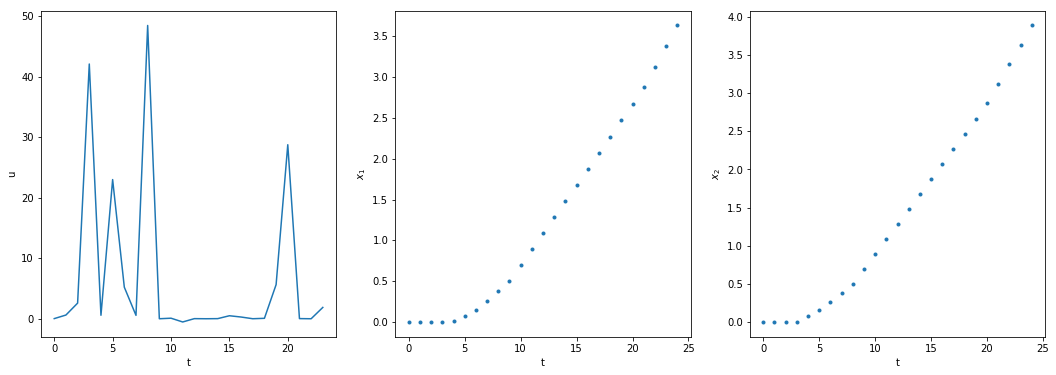

[ 2.33470797e-02  6.14017355e-01  2.58091476e+00  4.20959795e+01
  5.74221428e-01  2.29980097e+01  5.21476773e+00  5.61995917e-01
  4.84662261e+01  1.18419971e-04  9.09048605e-02 -5.33285722e-01
  1.80430593e-02  7.33908502e-04  1.98220169e-02  4.95883498e-01
  2.84449231e-01  3.49489738e-03  7.23310544e-02  5.63680777e+00
  2.87579749e+01  2.38364277e-02  1.72604415e-06  1.87220590e+00] -107.32309441735245   Presize =  0.1568   Error =  107.47989441735245
work time :     87.63


In [47]:
a = DiscreteSystem(25)
algorithm = DragonflySwarm(80, a.N_step, 980, 0.047, 0.063, 0.08, 0.95, 0.22, 0.74, 1, 1, 100000, 3, 0.5)

algorithm.Work(a)

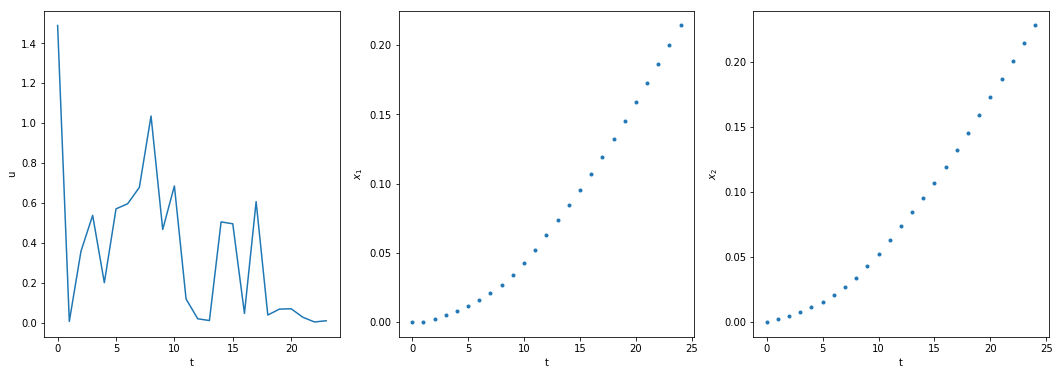

[1.49034795 0.00750761 0.35920956 0.53885643 0.20161833 0.57135598
 0.59716848 0.67925205 1.03663437 0.46825154 0.68629164 0.11976743
 0.02067007 0.01185031 0.50600726 0.49663594 0.04764474 0.60755483
 0.03945624 0.06922201 0.07084863 0.02834188 0.0046615  0.01089908] 0.08450323053426456   Presize =  0.1568   Error =  0.07229676946573543
work time :     57.82


In [35]:
a = DiscreteSystem(25)
algorithm = DragonflySwarm(70, a.N_step, 800, 0.05, 0.06, 0.07, 0.95, 0.22, 0.74, 1, 1, 100000, 3, 0.5)
algorithm.Work(a)

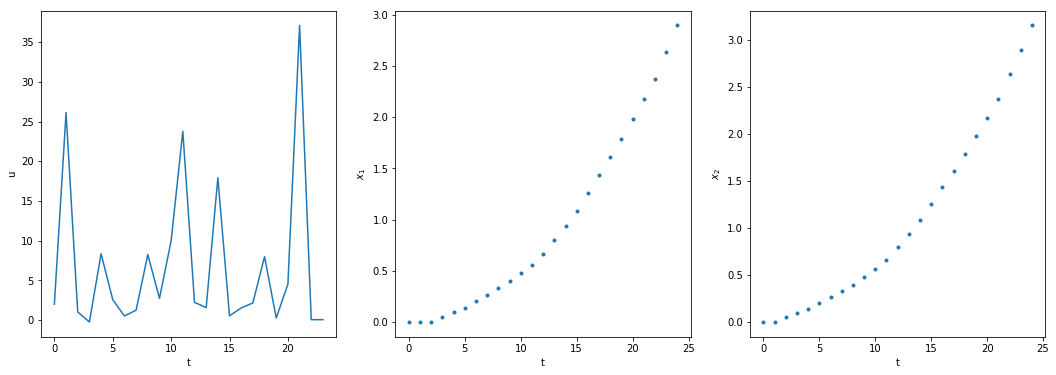

[ 2.01266007 26.15023019  1.03721907 -0.22669756  8.36618104  2.57317681
  0.52807393  1.26080115  8.26440457  2.75096997 10.00881682 23.7857479
  2.25528804  1.57374653 17.94383135  0.54922272  1.53778509  2.16771769
  8.00768142  0.27385413  4.53463743 37.13041797  0.06239125  0.06383923] -63.296068246624074   Presize =  0.1568   Error =  63.45286824662407
work time :    124.38


In [42]:
a = DiscreteSystem(25)
algorithm = DragonflySwarm(70, a.N_step, 1800, 0.03, 0.08, 0.07, 0.95, 0.22, 0.74, 1, 1, 100000, 3, 0.5)

algorithm.Work(a)

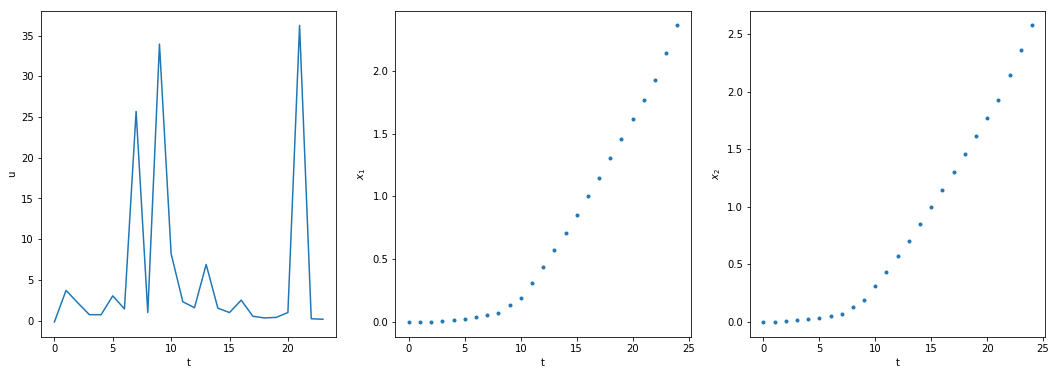

[-0.16917054  3.70965934  2.18996094  0.72673208  0.72259194  3.03709257
  1.43300384 25.69848413  0.99550768 33.97095235  8.20491163  2.31857161
  1.58338649  6.90070032  1.53180156  0.98717072  2.51238424  0.52820788
  0.32591093  0.39603409  0.99143876 36.25678793  0.22772112  0.16438333] -63.53916910144368   Presize =  0.1568   Error =  63.69596910144368
work time :    342.35


In [8]:
a = DiscreteSystem(25)
algorithm = DragonflySwarm(120, a.N_step, 1500, 0.05, 0.06, 0.07, 0.95, 0.22, 0.74, 1, 1, 100000, 3, 0.5)

algorithm.Work(a)

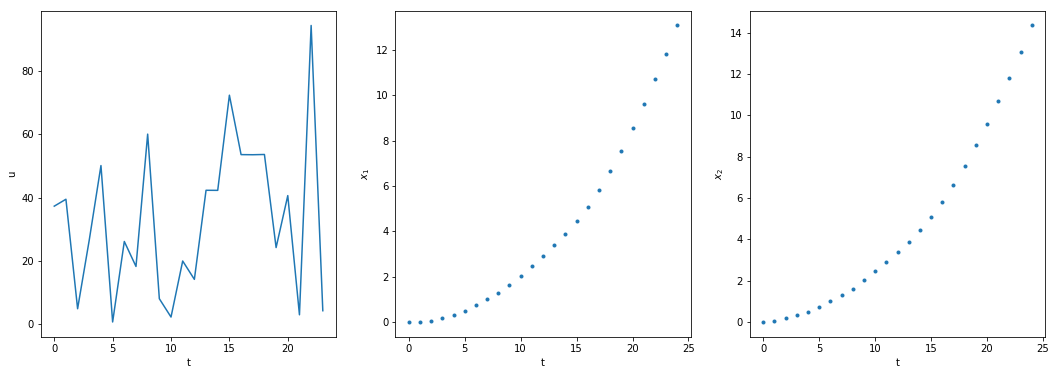

[37.30952933 39.49338167  4.94836035 26.68209158 50.11612542  0.7709202
 26.169508   18.28945736 60.03689882  8.10305715  2.32771313 20.00533798
 14.21454316 42.32153513 42.29716494 72.32127442 53.57222869 53.53578873
 53.61574647 24.24808037 40.64158096  3.03721041 94.32031064  4.32218544] -788.573520400901   Presize =  0.1568   Error =  788.730320400901
work time :    115.78


In [7]:
b = DiscreteSystem(25)
algorithm_ = DragonflySwarm(165, a.N_step, 500,  0.95, 1, 0.8, 0.5, 0.98, 0.3, 1, 1, 10, 2, 0.5)
algorithm_.Work(b)

# Вспомогательные функции для вывода значений векторов

In [32]:
algorithm.make_best_x(u)

In [71]:
print(algorithm.best_x1, algorithm.best_x2)

[0.        0.        3.6301029] [0.         3.6301029  9.44602777]


In [66]:
# for i in range(len(algorithm.population)):
#     print(algorithm.velocity_list[i])

In [708]:
 best_p = min(algorithm.population, key=lambda member: member.f)

In [709]:
print(best_p.u, best_p.f)

[32.84702181678559, 72.32152261790766, 78.0821131182933] -1542.142260237141


In [109]:
#algorithm.make_best_x(algorithm.best_list[0].u)

In [110]:
#algorithm.best_list[0].u

In [5]:
list_1 = [1.49034795, 0.00750761, 0.35920956, 0.53885643, 0.20161833, 0.57135598, 0.59716848, 0.67925205, 1.03663437, 0.46825154, 0.68629164, 0.11976743, 0.02067007, 0.01185031, 0.50600726, 0.49663594, 0.04764474, 0.60755483, 0.03945624, 0.06922201, 0.07084863, 0.02834188, 0.0046615, 0.01089908]

In [6]:
list_1

[1.49034795,
 0.00750761,
 0.35920956,
 0.53885643,
 0.20161833,
 0.57135598,
 0.59716848,
 0.67925205,
 1.03663437,
 0.46825154,
 0.68629164,
 0.11976743,
 0.02067007,
 0.01185031,
 0.50600726,
 0.49663594,
 0.04764474,
 0.60755483,
 0.03945624,
 0.06922201,
 0.07084863,
 0.02834188,
 0.0046615,
 0.01089908]

Text(0.5,0,'t')

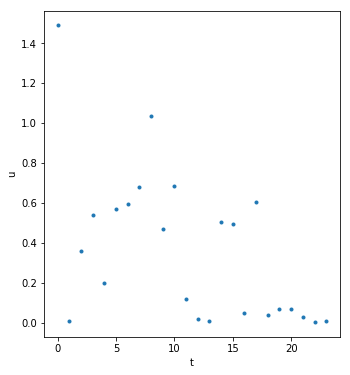

In [7]:
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
plt.plot(list_1, '.')
plt.ylabel('u')
plt.xlabel('t')

# Некоторые результаты

algorithm = DragonflySwarm(70, a.N_step, 800, 0.05, 0.06, 0.07, 0.95, 0.22, 0.74, 1, 1, 100000, 3, 0.5)
[1.49034795 0.00750761 0.35920956 0.53885643 0.20161833 0.57135598
 0.59716848 0.67925205 1.03663437 0.46825154 0.68629164 0.11976743
 0.02067007 0.01185031 0.50600726 0.49663594 0.04764474 0.60755483
 0.03945624 0.06922201 0.07084863 0.02834188 0.0046615  0.01089908] 0.08450323053426456   Presize =  0.1568   Error =  0.07229676946573543
work time :     57.82